In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kc-house-data/kc_house_data.csv


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet, BayesianRidge,RANSACRegressor,HuberRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

In [6]:
data = pd.read_csv('/kaggle/input/kc-house-data/kc_house_data.csv')
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21611 non-null  float64
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [8]:
data.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       2
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [9]:
data.fillna(0, inplace=True)

In [10]:
data.isnull().any().sum()

0

In [11]:
unique_dates = np.unique(data['date'].values)
print(len(unique_dates))

372


In [12]:
#format the date
d =[]
for i in data['date'].values:
    d.append(i[:4])

data['date'] = d

# convert everything to same datatype
for i in data.columns:
    data[i]=data[i].astype(float)

#make a new column age of the house
data['age'] = data['date'] - data['yr_built']

#calculate the total years of renovation
data['renov_age'] = np.abs(data['yr_renovated'] - data['yr_built'])

# data['renov_age'] = data.renov_age.apply(lambda x: x if len(str(int(x)))==2 else 0.0)

#remove unwanted columns like yr_built, date, id
data.drop(['id','date', 'yr_built', 'yr_renovated'], axis=1, inplace=True)
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,age,renov_age
0,221900.0,3.0,1.00,1180.0,5650.0,1.0,0.0,0.0,3.0,7.0,1180.0,0.0,98178.0,47.5112,-122.257,1340.0,5650.0,59.0,1955.0
1,538000.0,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3.0,7.0,2170.0,400.0,98125.0,47.7210,-122.319,1690.0,7639.0,63.0,40.0
2,180000.0,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3.0,6.0,770.0,0.0,98028.0,47.7379,-122.233,2720.0,8062.0,82.0,1933.0
3,604000.0,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5.0,7.0,1050.0,910.0,98136.0,47.5208,-122.393,1360.0,5000.0,49.0,1965.0
4,510000.0,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3.0,8.0,1680.0,0.0,98074.0,47.6168,-122.045,1800.0,7503.0,28.0,1987.0


### Dealing With Highly Correlated Features

In [13]:
data.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,age,renov_age
price,1.000000,0.308350,0.525138,0.702035,0.089661,0.256794,0.266369,0.397293,0.036362,0.667434,0.605416,0.323816,-0.053203,0.307003,0.021626,0.585379,0.082447,-0.053951,-0.119683
bedrooms,0.308350,1.000000,0.515884,0.576671,0.031703,0.175429,-0.006582,0.079532,0.028472,0.356967,0.477479,0.303093,-0.152668,-0.008931,0.129473,0.391638,0.029244,-0.154324,-0.006624
bathrooms,0.525138,0.515884,1.000000,0.754665,0.087740,0.500653,0.063744,0.187737,-0.124982,0.664983,0.685273,0.283770,-0.203866,0.024573,0.223042,0.568634,0.087175,-0.506407,-0.011111
sqft_living,0.702035,0.576671,0.754665,1.000000,0.172826,0.353949,0.103818,0.284611,-0.058753,0.762704,0.876288,0.435043,-0.199430,0.052529,0.240223,0.756420,0.183286,-0.318488,-0.030454
sqft_lot,0.089661,0.031703,0.087740,0.172826,1.000000,-0.005201,0.021604,0.074710,-0.008958,0.113621,0.183510,0.015286,-0.129574,-0.085683,0.229521,0.144608,0.718557,-0.052990,-0.004089
floors,0.256794,0.175429,0.500653,0.353949,-0.005201,1.000000,0.023698,0.029444,-0.263768,0.458183,0.523867,-0.245705,-0.059121,0.049614,0.125419,0.279885,-0.011269,-0.489640,0.031549
waterfront,0.266369,-0.006582,0.063744,0.103818,0.021604,0.023698,1.000000,0.401857,0.016653,0.082775,0.072076,0.080588,0.030285,-0.014274,-0.041910,0.086463,0.030703,0.026093,-0.094579
view,0.397293,0.079532,0.187737,0.284611,0.074710,0.029444,0.401857,1.000000,0.045990,0.251321,0.167673,0.276947,0.084827,0.006157,-0.078400,0.280439,0.072575,0.053458,-0.106609
condition,0.036362,0.028472,-0.124982,-0.058753,-0.008958,-0.263768,0.016653,0.045990,1.000000,-0.144674,-0.158195,0.174105,0.003026,-0.014941,-0.106500,-0.092824,-0.003406,0.360665,0.031367
grade,0.667434,0.356967,0.664983,0.762704,0.113621,0.458183,0.082775,0.251321,-0.144674,1.000000,0.755781,0.168392,-0.184862,0.114084,0.198372,0.713202,0.119248,-0.447415,0.019730


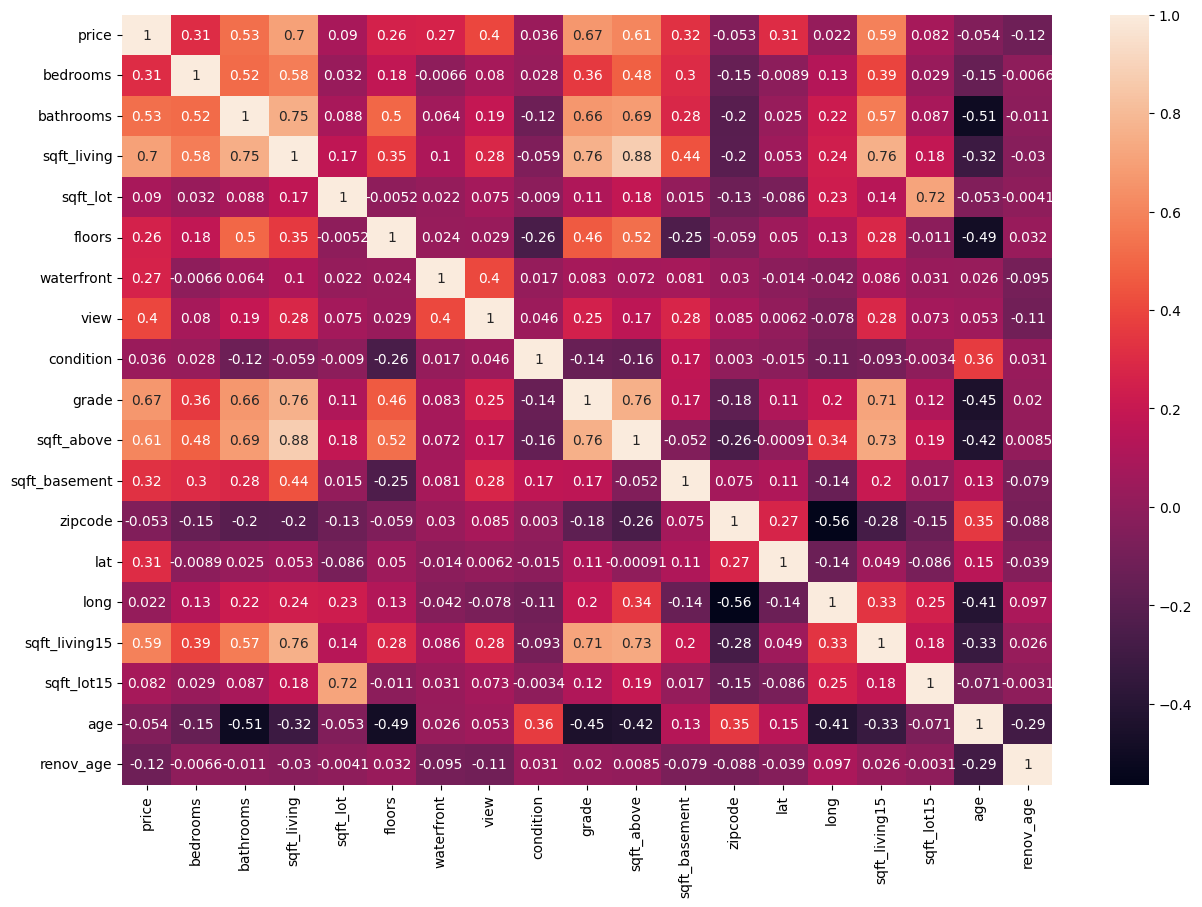

In [14]:
# plotting correlation heatmap
plt.figure(figsize=(15,10))
dataplot = sns.heatmap(data.corr(), annot=True)
plt.show()

In [15]:
corr_features = []
for i,r in data.corr().iterrows():
  k = 0 # counter
  for j in range(len(r)):
    if i != r.index[k]:
      if r.values[k] >= 0.5:
        corr_features.append([i, r.index[k], r.values[k]])
    k+=1
corr_features


[['price', 'bathrooms', 0.5251375054139628],
 ['price', 'sqft_living', 0.7020350546118005],
 ['price', 'grade', 0.6674342560202353],
 ['price', 'sqft_above', 0.6054162591641183],
 ['price', 'sqft_living15', 0.5853789035795692],
 ['bedrooms', 'bathrooms', 0.5158836376158312],
 ['bedrooms', 'sqft_living', 0.5766706925022448],
 ['bathrooms', 'price', 0.5251375054139628],
 ['bathrooms', 'bedrooms', 0.5158836376158312],
 ['bathrooms', 'sqft_living', 0.7546652789673752],
 ['bathrooms', 'floors', 0.5006531725878688],
 ['bathrooms', 'grade', 0.6649825338780723],
 ['bathrooms', 'sqft_above', 0.6852729704767271],
 ['bathrooms', 'sqft_living15', 0.568634289578226],
 ['sqft_living', 'price', 0.7020350546118005],
 ['sqft_living', 'bedrooms', 0.5766706925022448],
 ['sqft_living', 'bathrooms', 0.7546652789673752],
 ['sqft_living', 'grade', 0.7627044764584776],
 ['sqft_living', 'sqft_above', 0.8762879508115581],
 ['sqft_living', 'sqft_living15', 0.7564202590172237],
 ['sqft_lot', 'sqft_lot15', 0.71855

### Outliers

In [17]:
#let us numerically draw conclusions
#creating function that can calculate interquartile range of the data
def calc_interquartile(data, column):
    global lower, upper
    #calculating the first and third quartile
    first_quartile, third_quartile = np.percentile(data[column], 25), np.percentile(data[column], 75)
    #calculate the interquartilerange
    iqr = third_quartile - first_quartile
    # outlier cutoff (1.5 is a generally taken as a threshold)
    cutoff = iqr*1.5
    #calculate the lower and upper limits
    lower, upper = first_quartile - cutoff , third_quartile + cutoff
    #remove the outliers from the columns
    upper_outliers = data[data[column] > upper]
    lower_outliers = data[data[column] < lower]
    print('Lower outliers', lower_outliers.shape[0])
    print('Upper outliers', upper_outliers.shape[0])
    return print('total outliers', upper_outliers.shape[0] + lower_outliers.shape[0])

Lower outliers 0
Upper outliers 1146
total outliers 1146
1129575.0 -162625.0


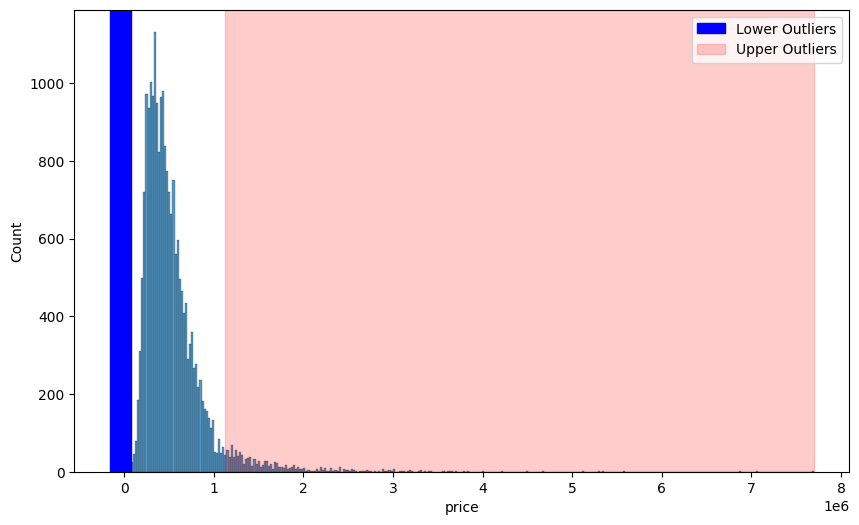

In [18]:
#plotting outliers graph for 'price' feature
calc_interquartile(data, 'price')
plt.figure(figsize = (10,6))
sns.histplot(data['price'], kde=False)
print(upper, lower)
plt.axvspan(xmin = lower,xmax= data['price'].min(),alpha=1, color='blue', label='Lower Outliers')
plt.axvspan(xmin = upper,xmax= data['price'].max(),alpha=0.2, color='red', label='Upper Outliers')
plt.legend(loc='upper right')
plt.show()

### Using ZScore

In [19]:
""" creating function for calculating zscore which is subtracting the mean from every data point and dividing by the standard deviation and if the zscore value of any data point
is less than -3 or greater than 3, then that data point is an outlier"""

# from scipy.stats import zscore

def z_score(data, column):
    #creating global variables for plotting the graph for better demonstration
    global zscore, outlier
    #creating lists to store zscore and outliers
    zscore = []
    outlier =[]
    # for zscore generally taken thresholds are 2.5, 3 or 3.5 hence i took 3
    threshold = 3
    # calculating the mean of the passed column
    mean = np.mean(data[column])
    # calculating the standard deviation of the passed column
    std = np.std(data[column])
    for i in data[column]:
        z = (i-mean)/std
        zscore.append(z)
        #if the zscore is greater than threshold = 3 that means it is an outlier
        if np.abs(z) > threshold:
            outlier.append(i)
    return print('total outliers', len(outlier))

total outliers 406
1129575.0 -162625.0


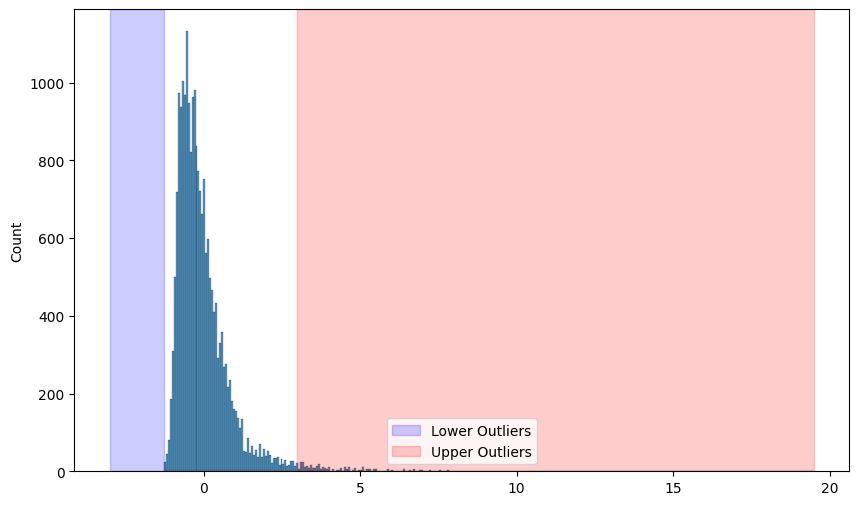

In [20]:
#plotting outliers graph for 'price' feature
z_score(data, 'price')
plt.figure(figsize = (10,6))
sns.histplot(zscore, kde=False)
print(upper, lower)
plt.axvspan(xmin = -3 ,xmax= min(zscore),alpha=0.2, color='blue', label='Lower Outliers')
plt.axvspan(xmin = 3 ,xmax= max(zscore),alpha=0.2, color='red', label='Upper Outliers')
plt.legend()
plt.show()

In [21]:
#remove the outliers from price using zscore
dj=[]
for i in data.price:
    if i in set(outlier):
        dj.append(0.0)
    else:
        dj.append(i)

data['P'] = dj

x = data.drop(data[data['P'] == 0.0].index)
x.shape

(21207, 20)

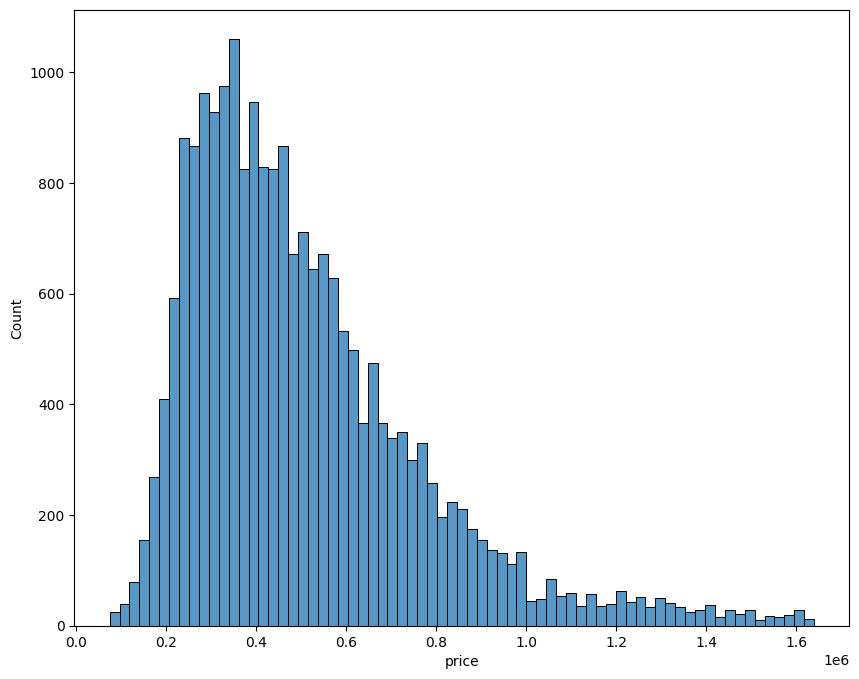

In [22]:
plt.figure(figsize = (10,8))
sns.histplot(x['price'], kde=False)
plt.show()

In [23]:
#isolation forest
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.ensemble import IsolationForest
iso = IsolationForest()
outlier = iso.fit_predict(data)

In [24]:
outlier

array([1, 1, 1, ..., 1, 1, 1])

In [25]:
print(set(outlier))

{1, -1}


In [26]:
#mask variable contains all the outliers
mask = outlier == -1
#task variable contains all the non-outliers data
task = outlier == 1
#creating dataframe containing outliers
df_1 = data[mask]
#creating dataframe containing non-outliers
df_2 = data[task]

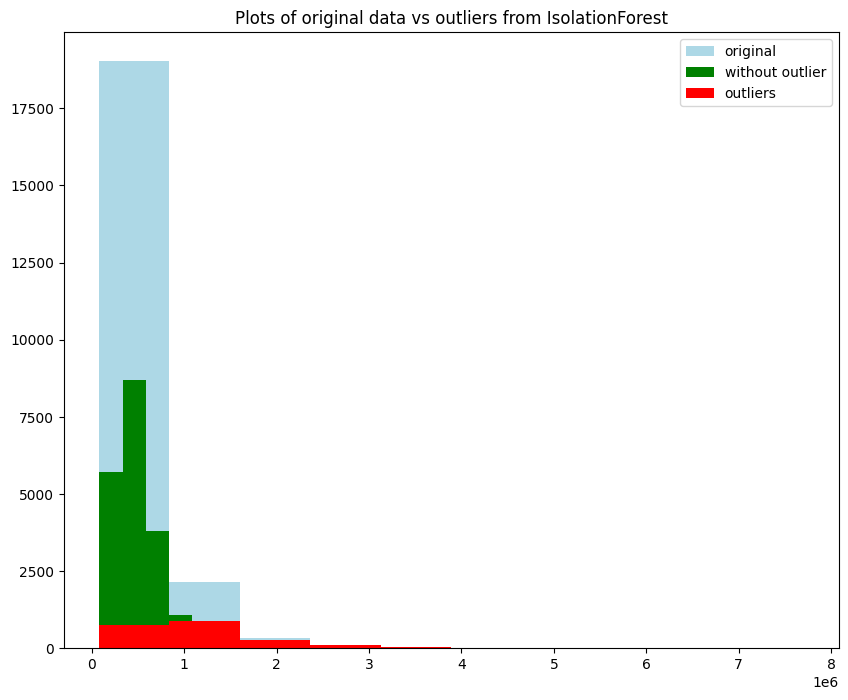

In [27]:
#plotting graph to show the original data, outliers and non-outliers
plt.figure(figsize=(10, 8))
plt.title('Plots of original data vs outliers from IsolationForest')
plt.hist(data['price'], label= 'original', color='lightblue')
plt.hist(df_2['price'], label='without outlier', color='green')
plt.hist(df_1['price'], label='outliers', color='red')
plt.legend()
plt.show()

### Model Building

In [28]:
X = x.drop(['price','P'], axis=1)
Y = x['price']

In [29]:
x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size=.3, random_state=1)

### Creating Pipeline for all models

In [30]:
sc = ('scaler', StandardScaler())
est = []
est.append(('LinearRegression', Pipeline([sc, ('LinearRegression', LinearRegression())])))
est.append(('Ridge', Pipeline([sc, ('Ridge', Ridge())])))
est.append(('Lasso', Pipeline([sc, ('Lasso', Lasso())])))
est.append(('BayesianRidge', Pipeline([sc, ('BayesianRidge', BayesianRidge())])))
est.append(('ElasticNet', Pipeline([sc, ('Elastic', ElasticNet())])))
est.append(('SGD', Pipeline([sc, ('SGD', SGDRegressor())])))
est.append(('Huber', Pipeline([sc,('Huber', HuberRegressor())])))
est.append(('RANSAC', Pipeline([sc,('RANSAC', RANSACRegressor())])))
est.append(('GradientBoosting', Pipeline([sc,('GradientBoosting',GradientBoostingRegressor())])))
est.append(('AdaBoost', Pipeline([sc, ('AdaBoost', AdaBoostRegressor())])))
est.append(('ExtraTree', Pipeline([sc,('ExtraTrees', ExtraTreesRegressor())])))
est.append(('RandomForest', Pipeline([sc,('RandomForest', RandomForestRegressor())]))) 
est.append(('Bagging', Pipeline([sc,('Bagging', BaggingRegressor())])))
est.append(('KNeighbors', Pipeline([sc,('KNeighbors', KNeighborsRegressor())])))
est.append(('DecisionTree', Pipeline([sc,('DecisionTree', DecisionTreeRegressor())])))
est.append(('XGB', Pipeline([sc,('XGB', XGBRegressor())])))

In [31]:
import warnings
warnings.filterwarnings('ignore')

models_score = []
for i in est:
  kfold = KFold(n_splits=10, random_state=1, shuffle=True)
  result = cross_val_score(i[1], x_train,y_train, cv=kfold, scoring='r2')
  models_score.append({i[0] : '{}'.format(result.mean())})

In [32]:
models_score

[{'LinearRegression': '0.714997864512686'},
 {'Ridge': '0.714998148505002'},
 {'Lasso': '0.7149385536214542'},
 {'BayesianRidge': '0.7150006330486589'},
 {'ElasticNet': '0.6787158193975812'},
 {'SGD': '0.7131289075105339'},
 {'Huber': '0.7082440201804096'},
 {'RANSAC': '-4.700408318681886e+19'},
 {'GradientBoosting': '0.8565118438871115'},
 {'AdaBoost': '0.6069829031440345'},
 {'ExtraTree': '0.8654030149220888'},
 {'RandomForest': '0.8630627062230742'},
 {'Bagging': '0.8498977203347666'},
 {'KNeighbors': '0.7810100527056537'},
 {'DecisionTree': '0.709879045729398'},
 {'XGB': '0.8740562212296833'}]

In [34]:
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

D0619 12:12:08.600463050      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0619 12:12:08.600491370      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0619 12:12:08.600495485      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0619 12:12:08.600498716      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0619 12:12:08.600501647      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0619 12:12:08.600504878      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0619 12:12:08.600508725      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0619 12:12:08.

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


### Hyperparameter Tuning

In [35]:
with strategy.scope():
    es =[]
    es.append(('XGB', Pipeline([sc,('XGB', XGBRegressor())])))

    best = []

    parameters = {
              
              'XGB': {'XGB__learning_rate': [0.1,0.2,0.3,0.4],
                         
                         'XGB__max_depth': [4,6,8],
                      'XGB__n_estimators': [100,500,1000,1500]}
             }

    for i in es:
        kfold = KFold(n_splits=10, random_state=1, shuffle=True)
        grid = GridSearchCV(estimator=i[1], param_grid = parameters[i[0]], cv = kfold, n_jobs=-1)
        grid.fit(x_train, y_train)
        best.append((i[0], grid.best_score_,  grid.best_params_))

In [36]:
best

[('XGB',
  0.8857988550014699,
  {'XGB__learning_rate': 0.1, 'XGB__max_depth': 4, 'XGB__n_estimators': 1000})]

In [ ]:
xgb = XGBRegressor(learning_rate=0.1, max_depth=4, n_estimators=1000)
xgb.fit(x_train, y_train)
pred = xgb.predict(x_test)

In [39]:
print(xgb.score(x_test,y_test))

0.8896661775503242


### Feature Selection

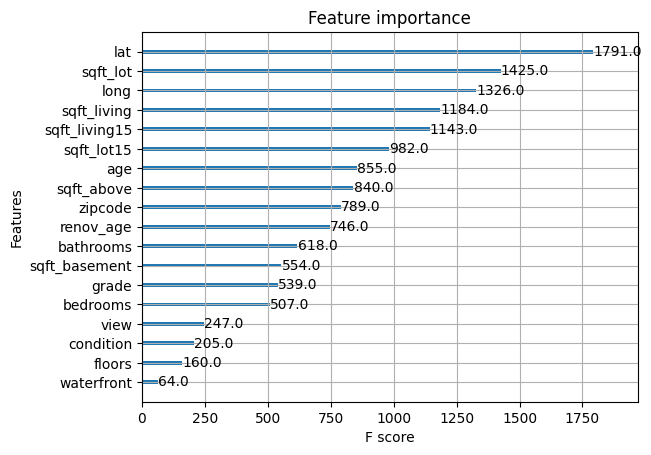

In [41]:
from xgboost import plot_importance
plot_importance(xgb)
plt.show()

I will use the top 9 features as my final fetaures to build my model and deploy it. I can also consider all these important features shown above. 
NB: **Lat** and **Long** are very important features in this regard. They are telling us that the location of the building is an important factor in determining the price or value of the property. The zip code is also telling us the same thing. In this example, I will omit the **Lat** and **Long** because if i do the deployment and I want people to check the value of their property, it is mostly difficult for them to provide the exact latitude and logitute of their property. In reality, I would have gone extra mile to collect extra data on the location of the properties or houses and add that data to my dataset which i can use to build my model instead of using latitude and longitude.

I will rather include the **zipcode** which also tells us the location of the houses.

In [42]:
SelectedFeatures = x[['sqft_lot','sqft_living15','age','zipcode','bathrooms','bedrooms','renov_age','sqft_basement','grade']]
SelectedFeatures.head()

,sqft_lot,sqft_living15,age,zipcode,bathrooms,bedrooms,renov_age,sqft_basement,grade
0,5650.0,1340.0,59.0,98178.0,1.00,3.0,1955.0,0.0,7.0
1,7242.0,1690.0,63.0,98125.0,2.25,3.0,40.0,400.0,7.0
2,10000.0,2720.0,82.0,98028.0,1.00,2.0,1933.0,0.0,6.0
3,5000.0,1360.0,49.0,98136.0,3.00,4.0,1965.0,910.0,7.0
4,8080.0,1800.0,28.0,98074.0,2.00,3.0,1987.0,0.0,8.0


In [54]:
x_train, x_test, y_train, y_test = train_test_split(SelectedFeatures, Y, test_size = 0.3, random_state=1)
xgb2 = XGBRegressor(learning_rate=0.1, max_depth=4, n_estimators=1000)
kfold = KFold(n_splits=10, random_state=1, shuffle=True)

In [56]:
with strategy.scope():
    result2 = cross_val_score(xgb2, x_train,y_train, cv=kfold, scoring='r2')
    

In [58]:
score2 = np.round(result2.mean(),2)
print(score2)

0.83


In [60]:
import pickle

# Creating a pickle file for the classifier
pickle.dump(xgb, open('model.pkl', 'wb'))